notes

- things to investigate
  - results of pubtator NER
  - results to bioconceptvec augmentation to mapping
- pubtator api: unreliable / unstable way to perform NER
  - some items got response, other similar items do not; 
  - wrong response received for session id?? "2257-9721-1859-6366"
  - can not cope with large volume of NER requests -- efo results pratically unreliable

In [1]:
# init

In [8]:
import json
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns

from funcs import utils, paths
from funcs.data_processing import stage1_processing

In [5]:
data_dir = utils.find_data_root()
print(data_dir)
pubtator_dir = data_dir / "output" / "pubtator"
assert pubtator_dir.exists()

/data/ik18445_cache/projects/vectology/stage2/data


In [16]:
terms_df_path = pubtator_dir / "terms_df.csv"
assert terms_df_path.exists()
session_df_path = pubtator_dir / "session_df_sanitized.csv"
assert session_df_path.exists()
ner_res_path = pubtator_dir / "ner_res.json"
assert ner_res_path.exists()

terms_df = pd.read_csv(terms_df_path)
print(terms_df.info())
session_df = pd.read_csv(session_df_path)
print(session_df.info())
with ner_res_path.open() as f:
    ner_res = pd.DataFrame(json.load(f))
    print(ner_res.info())
ner_res.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26571 entries, 0 to 26570
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   batch   26571 non-null  object
 1   term    26571 non-null  object
dtypes: object(2)
memory usage: 415.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26448 entries, 0 to 26447
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   batch       26448 non-null  object
 1   term        26448 non-null  object
 2   session_id  26448 non-null  object
dtypes: object(3)
memory usage: 620.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1349 entries, 0 to 1348
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   batch        1349 non-null   object
 1   mapping_id   1349 non-null   int64 
 2   term         1349 non-null   object
 3   session_id   1349 non-null   o

,batch,mapping_id,term,session_id,exists,session_res,ner_res
0,ebi,1,gonarthrosis,7562-9938-5522-3240,True,[00000\t0\t12\tgonarthrosis\tDisease],[None]
1,ebi,2,psoriatic and enteropathic arthropathies,9489-1267-1820-7640,True,[00000\t14\t40\tenteropathic arthropathies\tDi...,[Disease_MESH_D001177]
2,ebi,3,pain associated with micturition,2941-3822-8420-2463,True,[00000\t0\t4\tpain\tDisease\tMESH:D010146],[Disease_MESH_D010146]
3,ebi,8,gastritis and duodenitis,3350-1413-5269-5786,True,[00000\t0\t9\tgastritis\tDisease\tMESH:D005756...,"[Disease_MESH_D005756, Disease_MESH_D004382]"
4,ebi,10,pre existing hypertension complicating pregnan...,8353-1791-1234-4659,True,[00000\t13\t25\thypertension\tDisease\tMESH:D0...,"[Disease_MESH_D006973, None]"


In [23]:
# how many requests received api response

print("Num. terms, by batch")
print(terms_df.groupby("batch").size())

print("Num. items with ner results from API, by batch")
print(ner_res[["batch", "session_res"]]
      .assign(session_res=lambda df: df["session_res"].apply(lambda x: None if len(x) == 0 else x))
      .dropna().groupby("batch").size())

print("Num. items with identified entities, by batch")
print(ner_res[["batch", "ner_res"]]
      .assign(ner_res=lambda df: df["ner_res"]
              .apply(lambda x: [_ for _ in x if _ is not None])
              .apply(lambda x: None if len(x) == 0 else x))
      .dropna().groupby("batch").size())

Num. terms, by batch
batch
ebi     1191
efo    25380
dtype: int64
Num. items with ner results from API, by batch
batch
ebi    652
efo    697
dtype: int64
Num. items with identified entities, by batch
batch
ebi    639
efo    667
dtype: int64


In [25]:
# how many contain keys from embedding

from gensim.models import KeyedVectors
model_path = data_dir / ".." / "models" / "bioconceptvec" / "bioconceptvec_word2vec_skipgram.bin"
assert model_path.exists(), model_path

bioconceptvec_embeddings = KeyedVectors.load_word2vec_format(str(model_path), binary=True)

In [27]:
vocab_list = list(bioconceptvec_embeddings.key_to_index.keys())

print("Num. items with entities exists in embeddings, by batch")
print(ner_res[["batch", "ner_res"]]
      .assign(ner_res=lambda df: df["ner_res"]
              .apply(lambda x: [_ for _ in x if _ is not None and _ in vocab_list])
              .apply(lambda x: None if len(x) == 0 else x))
      .dropna().groupby("batch").size())

Num. items with entities exists in embeddings, by batch
batch
ebi    620
efo    659
dtype: int64


In [ ]:
# TODO: effects on augment on embeddings

---

# prelim effects of augment on top-1 mappings

In [40]:
ebi_df = stage1_processing.get_ebi_data()
ebi_df

2022-06-04 13:48:57.345 | INFO     | funcs.data_processing.stage1_processing:get_ebi_data:32 - <class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191 entries, 0 to 1190
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   query              1191 non-null   object
 1   MAPPED_TERM_LABEL  1191 non-null   object
 2   MAPPED_TERM_URI    1191 non-null   object
 3   MAPPING_TYPE       1191 non-null   object
 4   id                 1191 non-null   object
 5   full_id            1191 non-null   object
 6   mapping_id         1191 non-null   int64 
dtypes: int64(1), object(6)
memory usage: 65.3+ KB

2022-06-04 13:48:57.346 | INFO     | funcs.data_processing.stage1_processing:get_ebi_data:33 - 
Exact       603
Broad       527
Narrow       47
?             7
? Broad       3
? Narrow      2
? Exact       1
Narrow?       1
Name: MAPPING_TYPE, dtype: int64


,query,MAPPED_TERM_LABEL,MAPPED_TERM_URI,MAPPING_TYPE,id,full_id,mapping_id
0,gonarthrosis,osteoarthritis || knee,EFO_0004616,Broad,EFO_0004616,http://www.ebi.ac.uk/efo/EFO_0004616,1
1,psoriatic and enteropathic arthropathies,psoriatic arthritis,EFO_0003778,? Broad,EFO_0003778,http://www.ebi.ac.uk/efo/EFO_0003778,2
2,pain associated with micturition,dysuria,EFO_0003901,? Broad,EFO_0003901,http://www.ebi.ac.uk/efo/EFO_0003901,3
3,other mood,mood disorder,EFO_0004247,? Broad,EFO_0004247,http://www.ebi.ac.uk/efo/EFO_0004247,4
4,preterm delivery,premature birth,EFO_0003917,? Exact,EFO_0003917,http://www.ebi.ac.uk/efo/EFO_0003917,5
...,...,...,...,...,...,...,...
1186,malignant neoplasm without specification of site,cancer,EFO_0000311,Broad,EFO_0000311,http://www.ebi.ac.uk/efo/EFO_0000311,1187
1187,other and unspecified types of non-hodgkin's l...,non-Hodgkins lymphoma,EFO_0005952,Exact,EFO_0005952,http://www.ebi.ac.uk/efo/EFO_0005952,1188
1188,candidiasis,"Candidiasis, Invasive",EFO_1001283,Narrow,EFO_1001283,http://www.ebi.ac.uk/efo/EFO_1001283,1189
1189,other predominantly sexually transmitted disea...,bacterial sexually transmitted disease,EFO_0003955,Narrow,EFO_0003955,http://www.ebi.ac.uk/efo/EFO_0003955,1190


In [44]:
efo_df = stage1_processing.get_efo_nodes()
efo_df

2022-06-04 13:55:33.781 | INFO     | funcs.data_processing.stage1_processing:get_efo_nodes:24 - <class 'pandas.core.frame.DataFrame'>
Int64Index: 25380 entries, 0 to 25389
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   efo_label  25380 non-null  object
 1   efo_id     25380 non-null  object
dtypes: object(2)
memory usage: 594.8+ KB



,efo_label,efo_id
0,xeroderma pigmentosum variant,http://www.orpha.net/ORDO/Orphanet_90342
1,xeroderma pigmentosum,http://www.orpha.net/ORDO/Orphanet_910
2,ischemic stroke,http://purl.obolibrary.org/obo/HP_0002140
3,cerebral ischemia,http://purl.obolibrary.org/obo/HP_0002637
4,small cell carcinoma,http://www.ebi.ac.uk/efo/EFO_0008524
...,...,...
25385,acetazolamide-responsive myotonia,http://www.orpha.net/ORDO/Orphanet_99736
25386,complete androgen insensitivity syndrome,http://www.orpha.net/ORDO/Orphanet_99429
25387,intermediate dend syndrome,http://www.orpha.net/ORDO/Orphanet_99989
25388,epiblepharon,http://www.orpha.net/ORDO/Orphanet_99169


In [48]:
file_path = data_dir / "output" / "stage2-output" / "mapping_agg_intermediates" / "BioSentVec_1.0.csv"
assert file_path.exists(), file_path
b_mappings = pd.read_csv(file_path)
b_mappings

,mapping_id,manual,prediction,score,nx,MAPPING_TYPE
0,1,http://www.ebi.ac.uk/efo/EFO_0004616,http://www.ebi.ac.uk/efo/EFO_0004616,0.620142,1.0,Broad
1,2,http://www.ebi.ac.uk/efo/EFO_0003778,http://www.ebi.ac.uk/efo/EFO_0003778,0.697339,1.0,Other
2,8,http://www.ebi.ac.uk/efo/EFO_0000217,http://www.ebi.ac.uk/efo/EFO_0000217,0.892920,1.0,Broad
3,21,http://www.ebi.ac.uk/efo/EFO_0000685,http://www.ebi.ac.uk/efo/EFO_0000685,0.802925,1.0,Broad
4,24,http://www.ebi.ac.uk/efo/EFO_0001422,http://www.ebi.ac.uk/efo/EFO_0001422,0.853770,1.0,Broad
...,...,...,...,...,...,...
500,1175,http://www.ebi.ac.uk/efo/EFO_0002422,http://www.ebi.ac.uk/efo/EFO_0002422,0.717567,1.0,Exact
501,1176,http://www.ebi.ac.uk/efo/EFO_0008549,http://www.ebi.ac.uk/efo/EFO_0008549,0.620466,1.0,Exact
502,1180,http://purl.obolibrary.org/obo/HP_0001915,http://purl.obolibrary.org/obo/HP_0001915,0.743048,1.0,Exact
503,1185,http://www.ebi.ac.uk/efo/EFO_0009812,http://www.ebi.ac.uk/efo/EFO_0009812,0.696382,1.0,Broad


In [49]:
file_path = data_dir / "output" / "stage2-output" / "mapping_agg_intermediates" / "BioSentVec-BioConceptVec_1.0.csv"
assert file_path.exists(), file_path
bb_mappings = pd.read_csv(file_path)
bb_mappings

,mapping_id,manual,prediction,score,nx,MAPPING_TYPE
0,1,http://www.ebi.ac.uk/efo/EFO_0004616,http://www.ebi.ac.uk/efo/EFO_0004616,0.620142,1.0,Broad
1,2,http://www.ebi.ac.uk/efo/EFO_0003778,http://www.ebi.ac.uk/efo/EFO_0003778,0.620144,1.0,Other
2,8,http://www.ebi.ac.uk/efo/EFO_0000217,http://www.ebi.ac.uk/efo/EFO_0000217,0.777195,1.0,Broad
3,21,http://www.ebi.ac.uk/efo/EFO_0000685,http://www.ebi.ac.uk/efo/EFO_0000685,0.744603,1.0,Broad
4,24,http://www.ebi.ac.uk/efo/EFO_0001422,http://www.ebi.ac.uk/efo/EFO_0001422,0.695014,1.0,Broad
...,...,...,...,...,...,...
493,1175,http://www.ebi.ac.uk/efo/EFO_0002422,http://www.ebi.ac.uk/efo/EFO_0002422,0.717567,1.0,Exact
494,1176,http://www.ebi.ac.uk/efo/EFO_0008549,http://www.ebi.ac.uk/efo/EFO_0008549,0.620466,1.0,Exact
495,1180,http://purl.obolibrary.org/obo/HP_0001915,http://purl.obolibrary.org/obo/HP_0001915,0.714639,1.0,Exact
496,1185,http://www.ebi.ac.uk/efo/EFO_0009812,http://www.ebi.ac.uk/efo/EFO_0009812,0.696382,1.0,Broad


In [50]:
set_b = set(b_mappings["mapping_id"].tolist())
set_bb = set(bb_mappings["mapping_id"].tolist())
print(diff_b_bb := set_b.difference(set_bb))
print(diff_bb_b := set_bb.difference(set_b))

{148, 150, 278, 408, 152, 793, 798, 39, 553, 437, 581, 1094, 82, 467, 858, 736, 737, 865, 355, 114, 248, 380}
{448, 864, 546, 136, 842, 588, 144, 49, 830, 211, 601, 604, 829, 190, 159}


In [51]:
df_b_bb = b_mappings[b_mappings["mapping_id"].isin(diff_b_bb)].merge(
    ebi_df[["mapping_id", "query"]].rename(columns={"query": "ebi_label"}),
    on=["mapping_id"]
).merge(
    efo_df.rename(columns={"efo_label": "manual_label", "efo_id": "manual"}),
    on=["manual"]
).merge(
    efo_df.rename(columns={"efo_label": "prediction_label", "efo_id": "prediction"}),
    on=["prediction"]
)

df_bb_b = bb_mappings[bb_mappings["mapping_id"].isin(set2.difference(set1))].merge(
    ebi_df[["mapping_id", "query"]].rename(columns={"query": "ebi_label"}),
    on=["mapping_id"]
).merge(
    efo_df.rename(columns={"efo_label": "manual_label", "efo_id": "manual"}),
    on=["manual"]
).merge(
    efo_df.rename(columns={"efo_label": "prediction_label", "efo_id": "prediction"}),
    on=["prediction"]
)

In [52]:
df_b_bb.head()

,mapping_id,manual,prediction,score,nx,MAPPING_TYPE,ebi_label,manual_label,prediction_label
0,39,http://www.ebi.ac.uk/efo/EFO_0004280,http://www.ebi.ac.uk/efo/EFO_0004280,0.642810,1.0,Broad,other extrapyramidal and movement disorders,movement disorder,movement disorder
1,82,http://www.orpha.net/ORDO/Orphanet_79141,http://www.orpha.net/ORDO/Orphanet_79141,0.476358,1.0,Broad,corns and callosities,hereditary painful callosities,hereditary painful callosities
2,114,http://www.ebi.ac.uk/efo/EFO_1000705,http://www.ebi.ac.uk/efo/EFO_1000705,0.573882,1.0,Exact,granulomatous disorders of skin and subcutaneo...,granulomatous dermatitis,granulomatous dermatitis
3,148,http://www.ebi.ac.uk/efo/EFO_0003884,http://www.ebi.ac.uk/efo/EFO_0003884,0.600379,1.0,Exact,chronic renal failure,chronic kidney disease,chronic kidney disease
4,150,http://www.ebi.ac.uk/efo/EFO_0000249,http://www.ebi.ac.uk/efo/EFO_0000249,0.909603,1.0,Broad,dementia in alzheimer s disease,alzheimer's disease,alzheimer's disease


In [68]:
df_bb_b.head()

,mapping_id,manual,prediction,score,nx,MAPPING_TYPE,ebi_label,manual_label,prediction_label
0,49,http://www.ebi.ac.uk/efo/EFO_0009012,http://www.ebi.ac.uk/efo/EFO_0009012,0.708573,1.0,Broad,polyarteritis nodosa and related conditions,polyarteritis nodosa,polyarteritis nodosa
1,136,http://www.orpha.net/ORDO/Orphanet_97945,http://www.orpha.net/ORDO/Orphanet_97945,0.640830,1.0,Exact,other congenital malformations of intestine,intestinal malformation,intestinal malformation
2,144,http://www.ebi.ac.uk/efo/EFO_0000275,http://www.ebi.ac.uk/efo/EFO_0000275,0.824844,1.0,Exact,atrial fibrillation and flutter,atrial fibrillation,atrial fibrillation
3,159,http://www.ebi.ac.uk/efo/EFO_0002610,http://www.ebi.ac.uk/efo/EFO_0002610,0.557612,1.0,Broad,mental and behavioural disorders due to use of...,cocaine dependence,cocaine dependence
4,190,http://www.ebi.ac.uk/efo/EFO_0000763,http://www.ebi.ac.uk/efo/EFO_0000763,0.488145,1.0,Exact,viral infection of unspecified site,viral disease,viral disease


In [129]:
file_path = data_dir / "output" / "stage2-output" / "biosentvec-top-100.csv"
assert file_path.exists(), file_path

top100_b = pd.read_csv(file_path)

file_path = data_dir / "output" / "stage2-output" / "biosentvec-bioconceptvec-skipgram-top-100.csv"
assert file_path.exists(), file_path

top100_bb = pd.read_csv(file_path)

print(top100_b.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119100 entries, 0 to 119099
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   mapping_id  119100 non-null  int64  
 1   manual      119100 non-null  object 
 2   prediction  119100 non-null  object 
 3   score       118900 non-null  float64
 4   nx          119100 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 4.5+ MB
None


In [83]:
# tmp

MAPPING_ID = 49
# MAPPING_ID = 144
print("ebi_label: ", df_bb_b[df_bb_b["mapping_id"] == MAPPING_ID]["ebi_label"].tolist()[0])
truth = df_bb_b[df_bb_b["mapping_id"] == MAPPING_ID]["manual"].tolist()[0]
print("ground truth label: ", df_bb_b[df_bb_b["manual"] == truth]["manual_label"].tolist()[0])
top100_b_1 = top100_b[top100_b["mapping_id"] == MAPPING_ID].reset_index(drop=True).merge(
    ebi_df[["mapping_id", "query"]].rename(columns={"query": "ebi_label"}),
    on=["mapping_id"]
).merge(
    efo_df.rename(columns={"efo_label": "manual_label", "efo_id": "manual"}),
    on=["manual"]
).merge(
    efo_df.rename(columns={"efo_label": "prediction_label", "efo_id": "prediction"}),
    on=["prediction"]
)
print(top100_b_1.head())

ebi_label:  polyarteritis nodosa and related conditions
ground truth label:  polyarteritis nodosa
   mapping_id                                manual  \
0          49  http://www.ebi.ac.uk/efo/EFO_0009012   
1          49  http://www.ebi.ac.uk/efo/EFO_0009012   
2          49  http://www.ebi.ac.uk/efo/EFO_0009012   
3          49  http://www.ebi.ac.uk/efo/EFO_0009012   
4          49  http://www.ebi.ac.uk/efo/EFO_0009012   

                                     prediction     score        nx  \
0          http://www.ebi.ac.uk/efo/EFO_0009295  0.825995  0.954545   
1          http://www.ebi.ac.uk/efo/EFO_0009012  0.825995  1.000000   
2          http://www.ebi.ac.uk/efo/EFO_0006803  0.471154  0.476190   
3  http://purl.obolibrary.org/obo/MONDO_0018837  0.465952  0.416667   
4  http://purl.obolibrary.org/obo/MONDO_0017038  0.449660  0.233333   

                                     ebi_label          manual_label  \
0  polyarteritis nodosa and related conditions  polyarteritis nodosa   


In [88]:
# tmp

# MAPPING_ID = 82
MAPPING_ID = 148
# MAPPING_ID = 144
print("ebi_label: ", df_b_bb[df_b_bb["mapping_id"] == MAPPING_ID]["ebi_label"].tolist()[0])
truth = df_b_bb[df_b_bb["mapping_id"] == MAPPING_ID]["manual"].tolist()[0]
print("ground truth label: ", df_b_bb[df_b_bb["manual"] == truth]["manual_label"].tolist()[0])
top100_bb_1 = top100_bb[top100_bb["mapping_id"] == MAPPING_ID].reset_index(drop=True).merge(
    ebi_df[["mapping_id", "query"]].rename(columns={"query": "ebi_label"}),
    on=["mapping_id"]
).merge(
    efo_df.rename(columns={"efo_label": "manual_label", "efo_id": "manual"}),
    on=["manual"]
).merge(
    efo_df.rename(columns={"efo_label": "prediction_label", "efo_id": "prediction"}),
    on=["prediction"]
)
print(top100_bb_1.head())

ebi_label:  chronic renal failure
ground truth label:  chronic kidney disease
   mapping_id                                manual  \
0         148  http://www.ebi.ac.uk/efo/EFO_0003884   
1         148  http://www.ebi.ac.uk/efo/EFO_0003884   
2         148  http://www.ebi.ac.uk/efo/EFO_0003884   
3         148  http://www.ebi.ac.uk/efo/EFO_0003884   
4         148  http://www.ebi.ac.uk/efo/EFO_0003884   

                                  prediction     score        nx  \
0  http://purl.obolibrary.org/obo/HP_0000083  0.598127  0.111111   
1  http://www.orpha.net/ORDO/Orphanet_217330  0.565364  0.500000   
2       http://www.ebi.ac.uk/efo/EFO_1002048  0.560945  0.750000   
3       http://www.ebi.ac.uk/efo/EFO_1001226  0.545845  0.692308   
4       http://www.ebi.ac.uk/efo/EFO_0009909  0.532798  0.916667   

               ebi_label            manual_label  \
0  chronic renal failure  chronic kidney disease   
1  chronic renal failure  chronic kidney disease   
2  chronic renal failure  

---

# prelim effects of augment on top-n mappings

In [97]:
wa_top1_path = data_dir / "output" / "stage2-output" / "weighted_average_top1_df.csv"
wa_top10_path = data_dir / "output" / "stage2-output" / "weighted_average_top10_df.csv"
assert wa_top1_path.exists(), wa_top1_path
assert wa_top10_path.exists(), wa_top10_path

wa_top1 = pd.read_csv(wa_top1_path)
print(wa_top1.shape)
wa_top1 = wa_top1[wa_top1["Model"].isin(["BioSentVec", "BioSentVec-BioConceptVec"]) ].reset_index(drop=True)
print(wa_top1.shape)

wa_top10 = pd.read_csv(wa_top10_path)
print(wa_top10.shape)
wa_top10 = wa_top10[wa_top10["Model"].isin(["BioSentVec", "BioSentVec-BioConceptVec"]) ].reset_index(drop=True)
print(wa_top10.shape)

(11770, 3)
(2354, 3)
(10593, 3)
(2354, 3)


In [98]:
wa_top1.groupby("Model").describe()

value                                               \
                           count      mean       std   min    25%    50%  75%   
Model                                                                           
BioSentVec                1177.0  0.647025  0.381440  0.02  0.214  0.833  1.0   
BioSentVec-BioConceptVec  1177.0  0.639092  0.383422  0.02  0.190  0.833  1.0   

                               
                          max  
Model                          
BioSentVec                1.0  
BioSentVec-BioConceptVec  1.0

In [94]:
wa_top10.groupby("Model").describe()

value                                           \
                           count      mean       std    min    25%    50%   
Model                                                                       
BioSentVec                1177.0  0.453681  0.186196  0.058  0.314  0.454   
BioSentVec-BioConceptVec  1177.0  0.446778  0.186652  0.058  0.311  0.445   

                                        
                            75%    max  
Model                                   
BioSentVec                0.594  0.923  
BioSentVec-BioConceptVec  0.587  0.923

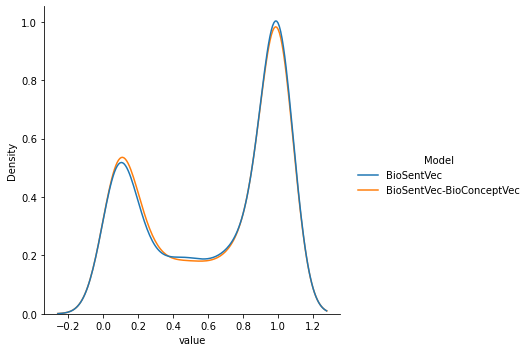

In [99]:
sns.displot(
    x="value",
    hue="Model",
    kind="kde",
    data=wa_top1
)

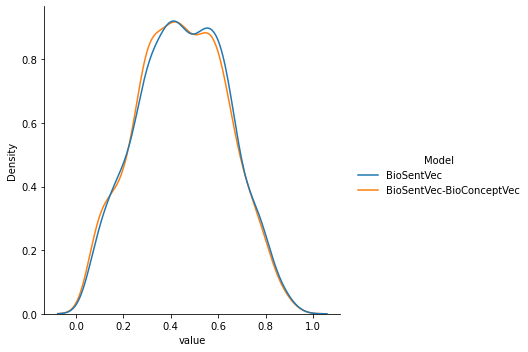

In [96]:
sns.displot(
    x="value",
    hue="Model",
    kind="kde",
    data=wa_top10
)

# pubtator issues

In [29]:
concat_df = terms_df.merge(ner_res, on=["batch", "term"], how="left")
print(concat_df.info())
concat_df.to_csv(data_dir / "output" / "tmp" / "concat.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26571 entries, 0 to 26570
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   batch        26571 non-null  object 
 1   term         26571 non-null  object 
 2   mapping_id   1354 non-null   float64
 3   session_id   1354 non-null   object 
 4   exists       1354 non-null   object 
 5   session_res  1354 non-null   object 
 6   ner_res      1354 non-null   object 
dtypes: float64(1), object(6)
memory usage: 1.6+ MB
None


In [31]:
foo =  ner_res[ner_res["session_id"] == "2257-9721-1859-6366"]
foo

,batch,mapping_id,term,session_id,exists,session_res,ner_res
1336,efo,23436,metaphyseal chondrodysplasia jansen type,2257-9721-1859-6366,True,[33787412\t50\t74\tcoronavirus disease 2019\tD...,"[Disease_MESH_C000657245, Disease_MESH_C000657..."


In [37]:
"\n".join(foo["session_res"].tolist()[0])[:1000]

'33787412\t50\t74\tcoronavirus disease 2019\tDisease\tMESH:C000657245\n33787412\t76\t84\tCOVID-19\tDisease\tMESH:C000657245\n33787412\t112\t146\trespiratory syndrome coronavirus 2\tDisease\tMESH:D018352\n33787412\t148\t158\tSARS-CoV-2\tDisease\tMESH:C000657245\n33787412\t558\t568\tSARS-CoV-2\tDisease\tMESH:C000657245\n33787412\t655\t660\tCLIAs\tDisease\n33787412\t929\t937\tCOVID-19\tDisease\tMESH:C000657245\n33787412\t1485\t1489\tLFIA\tDisease\n\n34668736|t|\n34668736|a|Isothermal amplification-based tests have been introduced as rapid, low-cost, and simple alternatives to real-time reverse transcriptase PCR (RT-PCR) tests for severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) detection. The clinical performance of two isothermal amplification-based tests (Atila Biosystems iAMP coronavirus disease of 2019 [COVID-19] detection test and OptiGene COVID-19 direct plus RT-loop-mediated isothermal amplification [LAMP] test) was compared with that of clinical RT-PCR assays using dif

In [38]:
foo["ner_res"].tolist()[0][:20]

['Disease_MESH_C000657245',
 'Disease_MESH_C000657245',
 'Disease_MESH_D018352',
 'Disease_MESH_C000657245',
 'Disease_MESH_C000657245',
 None,
 'Disease_MESH_C000657245',
 None,
 None,
 None,
 None,
 'Disease_MESH_D018352',
 'Disease_MESH_C000657245',
 'Disease_MESH_C000657245',
 'Disease_MESH_C000657245',
 'Disease_MESH_C000657245',
 'Disease_MESH_C000657245',
 'Disease_MESH_C000657245',
 'Disease_MESH_C000657245',
 'Disease_MESH_C000657245']